# Style Transfer using GAN



In [1]:
#import required libraries

import os
from os import listdir
import numpy as np
from numpy import asarray
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
% matplotlib inline
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!ls '/content/gdrive/My Drive/MRI_Dataset'

Tr1  Tr2


## Data Understanding

Import the images and create two seperate datasets. The input shape for image should be (256, 256) 

In [4]:
#load image and resize images
def load_images(path, size=(256,256)):
  data_list = list()

  for filename  in listdir(path):
    pixels = load_img(path + filename, target_size=size)
    #coverting to numpy array
    pixels = img_to_array(pixels)
    #storing data
    data_list.append(pixels)
  return asarray(data_list)

In [5]:
#load dataset tr1
tr1_data = load_images('/content/gdrive/My Drive/MRI_Dataset/Tr1/TrainT1/')
tr1_data = tf.image.rgb_to_grayscale(tr1_data)
tr1 = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(tr1_data))
tr1

<TensorSliceDataset shapes: (256, 256, 1), types: tf.float32>

In [6]:
#load dataset tr2
tr2_data = load_images('/content/gdrive/My Drive/MRI_Dataset/Tr2/TrainT2/')
tr2_data = tf.image.rgb_to_grayscale(tr2_data)
tr2 = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(tr2_data))
tr2

<TensorSliceDataset shapes: (256, 256, 1), types: tf.float32>

## Image Processing

- Creating a function to process images with normalisation.
- Applying function to both datasets.
- Visualise the MRI images after processing.

In [7]:
buffer_size = 1000
batch_size = 1

In [8]:
#normalize the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [9]:
#prepocessing images
def preprocess_train_image(image):
  image = tf.image.random_flip_left_right(image)
  image = normalize(image)
  return image

In [10]:
#process both classes of MRI images
AUTOTUNE = tf.data.experimental.AUTOTUNE
tr1 = tr1 .map(preprocess_train_image, num_parallel_calls=AUTOTUNE).cache().shuffle(buffer_size).batch(batch_size)
tr2 = tr2 .map(preprocess_train_image, num_parallel_calls=AUTOTUNE).cache().shuffle(buffer_size).batch(batch_size)

In [11]:
sample_tr1 = next(iter(tr1))
sample_tr2 = next(iter(tr2))

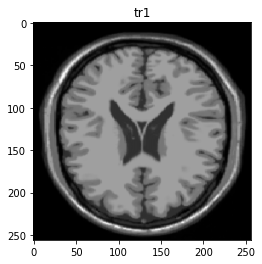

In [12]:
plt.title('tr1')
plt.imshow(sample_tr1[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap = 'gray')

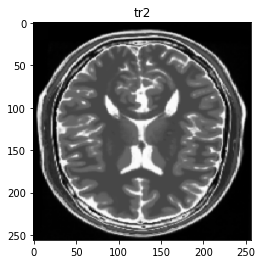

In [13]:
plt.title('tr2')
plt.imshow(sample_tr2[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap = 'gray')

##Model Building and Training

The architecture of generator is a modified U-Net.
- Creating Generator and Discriminator
- Defining the loss functions
- Creating the train_step function 

In [14]:
class InstanceNormalization(tf.keras.layers.Layer):
  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon
  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer = tf.random_normal_initializer(1., 0.02),
        trainable=True)
    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)
  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

def downsample(filters, size, apply_norm=True):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
  if apply_norm:
    result.add(InstanceNormalization())
  result.add(tf.keras.layers.LeakyReLU())
  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
  result.add(InstanceNormalization())
  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))
  result.add(tf.keras.layers.ReLU())
  return result

In [15]:
def unet_generator():

  #creating a stack of downsample model 
  down_stack = [
      downsample(64, 4, apply_norm=False),
      downsample(128, 4),
      downsample(256, 4),
      downsample(512, 4),
      downsample(512, 4),
      downsample(512, 4),
      downsample(512, 4),
      downsample(512, 4)
  ]

  #creating a stack of upsample model 
  up_stack = [
      upsample(512, 4, apply_dropout=True),
      upsample(512, 4, apply_dropout=True),
      upsample(512, 4, apply_dropout=True),
      upsample(512, 4),
      upsample(256, 4),
      upsample(128, 4),
      upsample(64, 4)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')
  concat = tf.keras.layers.Concatenate()
  inputs = tf.keras.layers.Input(shape=[None, None, 1])
  x = inputs
  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
  skips = reversed(skips[:-1])
  # Upsampling and establishing the skip connection
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])
  x = last(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

In [16]:
# intiialise the generator
generator_g = unet_generator()
generator_f = unet_generator()

In [17]:
def discriminator():
  initializer =  tf.random_normal_initializer(0., 0.02)
  inp = tf.keras.layers.Input(shape=[None, None, 1], name='input_image')
  x = inp
  down1 = downsample(64, 4, False)(x)
  down2 = downsample(128, 4)(down1)
  down3 = downsample(256, 4)(down2)
  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,use_bias=False)(zero_pad1)
  norm1 = InstanceNormalization()(conv)
  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
  last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)
  return tf.keras.Model(inputs=inp, outputs=last)

In [18]:
# initailise the discriminator
discriminator_x = discriminator()
discriminator_y = discriminator()

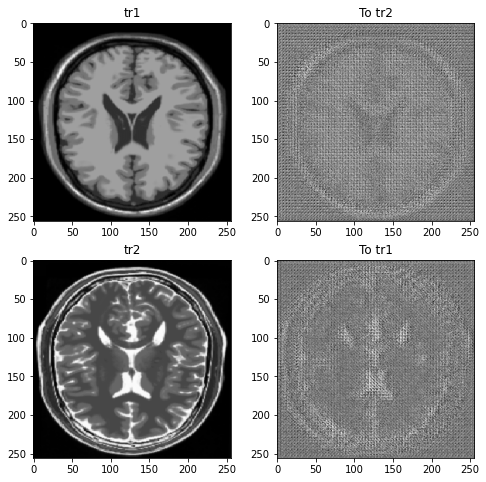

In [19]:
to_tr2 = generator_g(sample_tr1)
to_tr1 = generator_f(sample_tr2)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_tr1, to_tr2, sample_tr2, to_tr1]
title = ['tr1', 'To tr2', 'tr2', 'To tr1']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
  else:
    plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 + contrast + 0.5, cmap='gray')
plt.show()

In [20]:
LAMBDA =  10

In [21]:
# Using Binary Cross Entropy with logits true 
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
# calculating discriminator loss by summing the real and generated
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5

In [23]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [24]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  return LAMBDA * loss1

In [25]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [26]:
#Optimizer with learning rate 0.0001 for generator and discriminator
generator_g_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)

In [27]:
epochs = 20

In [28]:
checkpoint_path = './checkpoints'
ckpt = tf.train.Checkpoint(generator_g=generator_g, generator_f=generator_f,
                           discriminator_x=discriminator_x, discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer, generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer, discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=epochs)
# If a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest Checkpoint Restored')

In [29]:
def generate_images(model, test_input, expected_output):
  prediction = model(test_input)
  plt.figure(figsize=(10,10))
  display_list = [test_input[0], prediction[0], expected_output[0]]
  title = ['Input Image', 'Predicted Image', 'Expected Image']
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
    plt.axis('off')
  plt.show()    

In [30]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients  
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y.
    # Generator F translates Y -> X.
    fake_y = generator_g(real_x, training=True) # Code to generate images using Generator_g on real_x.
    cycled_x = generator_f(fake_y, training=True) # Code to generate images using Generator_f on fake_y.

    fake_x = generator_f(real_y, training=True) # Code to generate images using Generator_f on real_y.
    cycled_y = generator_g(fake_x, training=True) # Code to generate images using Generator_g on fake_x.

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True) # Code to generate images using Generator_f on real_x.
    same_y = generator_g(real_y, training=True) # Code to generate images using Generator_g on real_y.

    disc_real_x = discriminator_x(real_x, training = True) # Code to discriminate images using Discriminator_x on real_x.
    disc_real_y = discriminator_y(real_y, training = True) # Code to discriminate images using Discriminator_y on real_y.

    disc_fake_x = discriminator_x(fake_x, training= True) # Code to discriminate images using Discriminator_x on fake_x.
    disc_fake_y = discriminator_y(fake_y, training = True) # Code to discriminate images using Discriminator_y on fake_y.

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y) # calculate the generator_loss for disc_fake_y
    gen_f_loss = generator_loss(disc_fake_x) # calculate the generator_loss for disc_fake_x

    # calculate the total_cycle_loss
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x) # calculate the discriminator_loss for disc_fake_x wrt disc_real_x.
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y) # calculate the discriminator_loss for disc_fake_y wrt disc_real_y.

  #calculate the gredients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

  # Apply gredients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

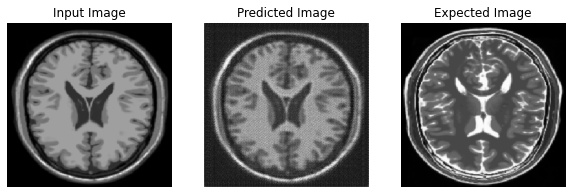

Saving checkpoint for epoch 1 at ./checkpoints/ckpt-1


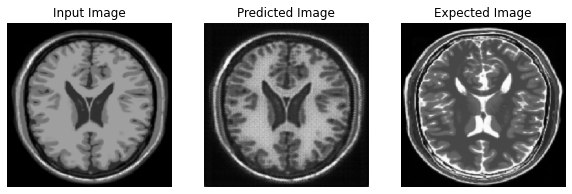

Saving checkpoint for epoch 2 at ./checkpoints/ckpt-2


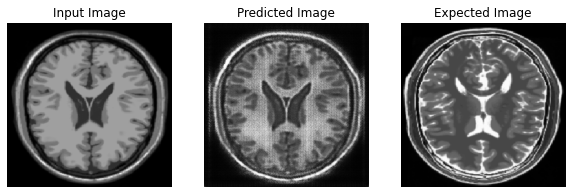

Saving checkpoint for epoch 3 at ./checkpoints/ckpt-3


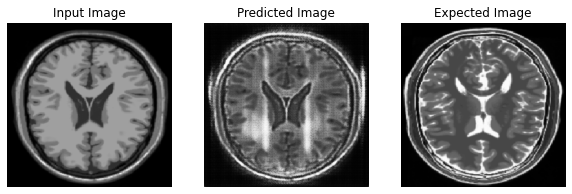

Saving checkpoint for epoch 4 at ./checkpoints/ckpt-4


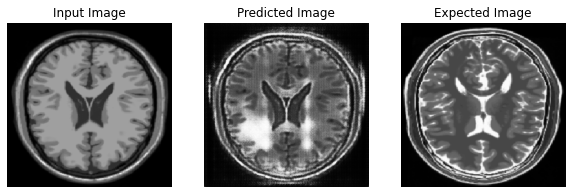

Saving checkpoint for epoch 5 at ./checkpoints/ckpt-5


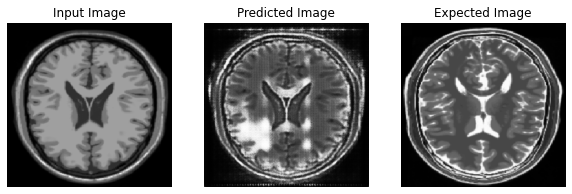

Saving checkpoint for epoch 6 at ./checkpoints/ckpt-6


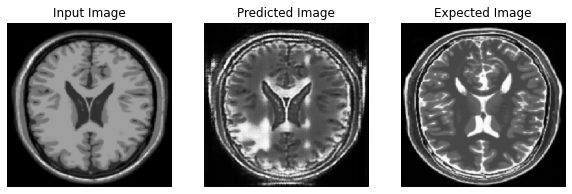

Saving checkpoint for epoch 7 at ./checkpoints/ckpt-7


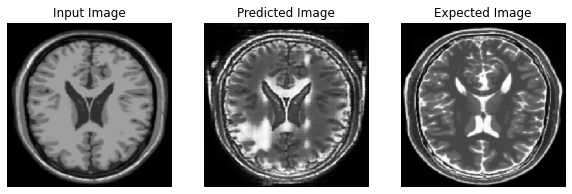

Saving checkpoint for epoch 8 at ./checkpoints/ckpt-8


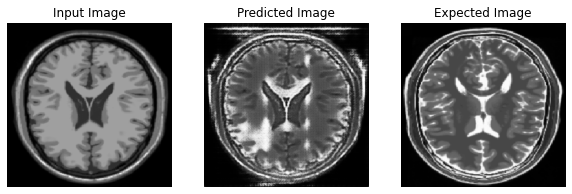

Saving checkpoint for epoch 9 at ./checkpoints/ckpt-9


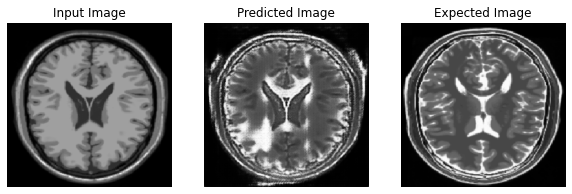

Saving checkpoint for epoch 10 at ./checkpoints/ckpt-10


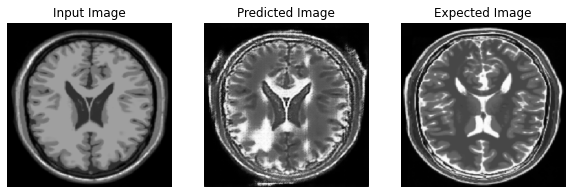

Saving checkpoint for epoch 11 at ./checkpoints/ckpt-11


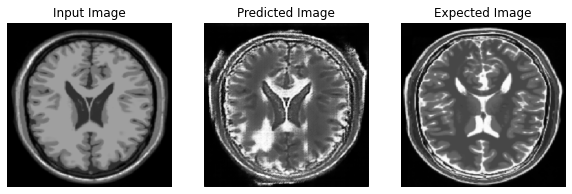

Saving checkpoint for epoch 12 at ./checkpoints/ckpt-12


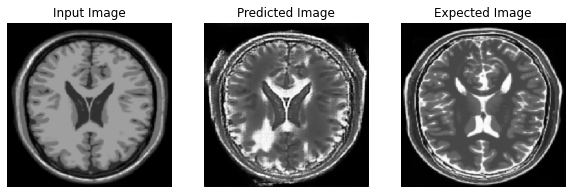

Saving checkpoint for epoch 13 at ./checkpoints/ckpt-13


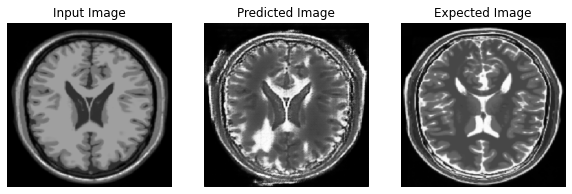

Saving checkpoint for epoch 14 at ./checkpoints/ckpt-14


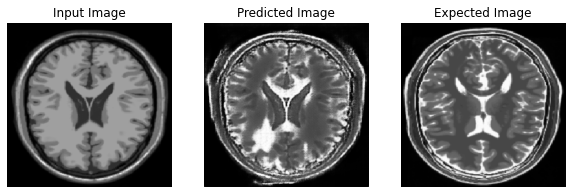

Saving checkpoint for epoch 15 at ./checkpoints/ckpt-15


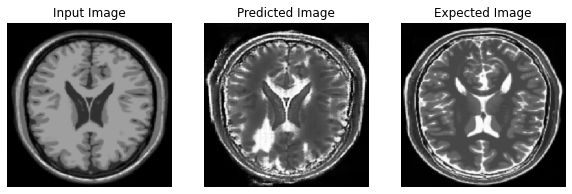

Saving checkpoint for epoch 16 at ./checkpoints/ckpt-16


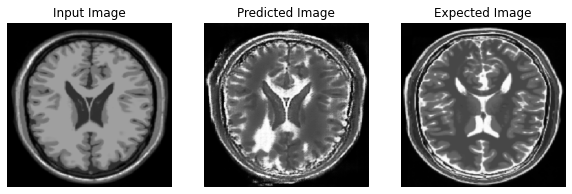

Saving checkpoint for epoch 17 at ./checkpoints/ckpt-17


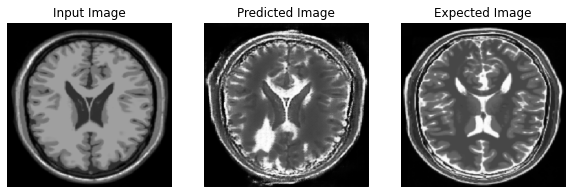

Saving checkpoint for epoch 18 at ./checkpoints/ckpt-18


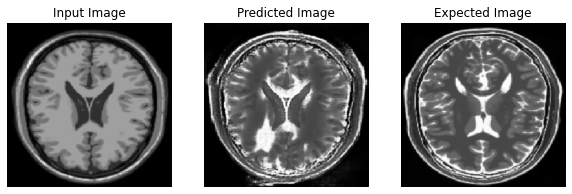

Saving checkpoint for epoch 19 at ./checkpoints/ckpt-19


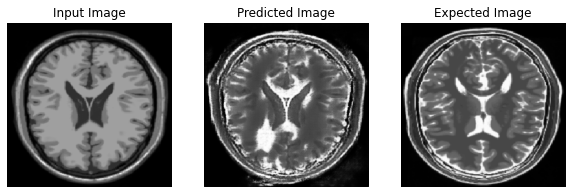

Saving checkpoint for epoch 20 at ./checkpoints/ckpt-20


In [31]:
for epoch in range(epochs):
  for image_x, image_y in tf.data.Dataset.zip((tr1, tr2)):
    train_step(image_x, image_y)
  generate_images(generator_g, sample_tr1, sample_tr2)
  ckpt_save_path = ckpt_manager.save()
  print('Saving checkpoint for epoch', epoch+1, 'at', ckpt_save_path)

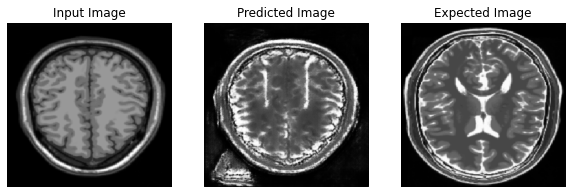

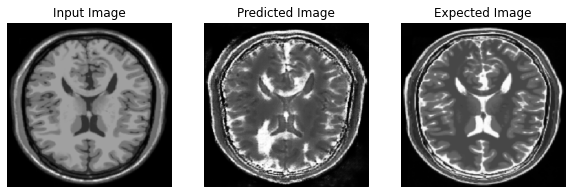

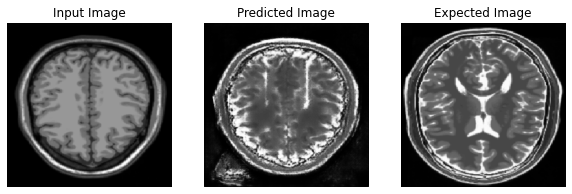

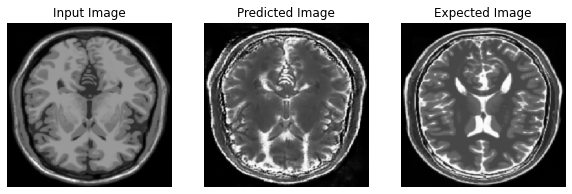

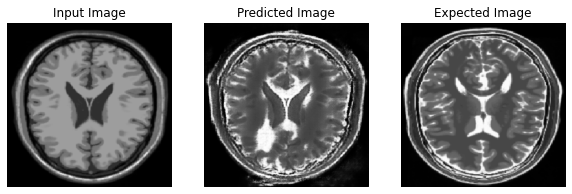

In [32]:
# run the trained model on the test dataset
for inp in tr1.take(5):
  generate_images(generator_g, inp, sample_tr2)

In [33]:
!rm -rf checkpoints